# Tâche #1 : Prédiction du score NOVA d'aliments avec des modèles *Transformers*

On reprend, comme au premier travail, la tâche de prédiction du score NOVA de produits alimentaires. Cependant, des nouveaux jeux de données ont été produits. Le corpus de textes contient 3 partitions :
-	Un fichier d’entraînement -  *data/t1_nova_train.json*
-	Un fichier de validation -  *data/t1_nova_dev.json*
-	Un fichier de test - *data/t1_nova_test.json*

Utilisez la librairie *HuggingFace* pour accomplir cette tâche. On vous demande plus spécifiquement d’utiliser 2 modèles: le modèle ***bert-base-uncased*** et un **modèle encodeur multilingue** de votre choix.

Les consignes pour cette tâche sont :
- Nom du notebook : *t1_classification_nova.ipynb* (ce notebook).
- Tokenisation : Celle fournie par les tokeniseurs accompagnant les modèles transformers.
- Plongements de mots : Ceux du modèle *transformer*.
- Normalisation : Lettre en minuscule pour Bert (rien à faire, le tokenizer s’en occupe). Aucune contrainte pour le 2e modèle mais il est préférable de comparer les modèles sur une même base (lettres minuscules).
- Choix du 2e transformer: Un modèle encodeur multilingue préentraîné. Le modèle peut être une variante de Bert, mais cela n'est pas exigé. Me consulter en cas de doute pour valider votre choix.
- Entraînement : Un affinage (*fine-tuning*) des modèles encodeurs. Pas de pré-entraînement (*no further pretraining*) demandé pour cette tâche.
- Analyse : Présentez clairement vos résultats et faites-en l’analyse. Comparez les résultats obtenus avec les 2 modèles.    

Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2, etc.) si cela améliore la lisibilité.

Vous pouvez diviser cette tâche en 2 *notebooks* (un pour chaque modèle) si cela est plus simple pour vous. Dans ce cas, ajoutez le nom du modèle dans le nom du fichier (par ex. *t1_classification_nova_bert.ipynb*) et retirez les cellules prévues pour le 2e modèle.  

Notes :
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc.
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement des modèles.
- Vous pouvez ajouter des cellules au *notebook* comme bon vous semble.

Si nécessaire, installez les *packages* suivant. Si vous exécutez sur Code Colab, ces *packages* devraient déjà être installés.

In [7]:
!pip install datasets
#!pip install accelerate
#!pip install "transformers[torch]"
#!pip3 install torch torchvision
#!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 43.4 MB/s eta 0:00:00


In [8]:
import os

In [9]:

IN_COLAB = False

dossier_cible = '/content/drive/MyDrive/uni/nlp/nlp_tp2_models'
raccourci = '/content/nlp_tp2_models'

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

#Mount a google drive folder to save models
if IN_COLAB:
  drive.mount('/content/drive')
  os.symlink(dossier_cible, raccourci)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileExistsError: [Errno 17] File exists: '/content/drive/MyDrive/uni/nlp/nlp_tp2_models' -> '/content/nlp_tp2_models'

In [ ]:
repo_url = "https://github.com/XavyShmore/tp2_nlp.git"
if IN_COLAB:
  !git clone {repo_url}
  !cp -r ./tp2_nlp/data .

## 1. Création du jeu de données (*les 3 partitions du dataset*)

In [10]:
train_json_fn = "./data/t1_nova_train.json"  # Jeu de données d'entraînement
dev_json_fn = "./data/t1_nova_dev.json"  # Jeu de données de validation
test_json_fn = "./data/t1_nova_test.json"  # Jeu de données de test

In [11]:
from datasets import Dataset

label2id = {"Groupe 1": 0, "Groupe 2": 1, "Groupe 3": 2, "Groupe 4": 3}
id2label = {0: "Groupe 1", 1: "Groupe 2", 2: "Groupe 3", 3: "Groupe 4"}

def load_data(json_fn):
    dataset = Dataset.from_json(json_fn)
    dataset = dataset.map(lambda nova_group: {"labels": label2id[nova_group["nova"]]})
    return dataset

In [12]:
train_dataset = load_data(train_json_fn)
dev_dataset = load_data(dev_json_fn)
test_dataset = load_data(test_json_fn)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/7651 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2126 [00:00<?, ? examples/s]

## 2. Classification des scores NOVA avec BERT

### 2.1 Modèle BERT


In [13]:
model_id = "bert-base-uncased"

In [14]:
from transformers import AutoTokenizer

def tokenize_dataset(data_set, tokenizer):
    return data_set.map(lambda examples: tokenizer(examples['text'], padding="max_length", truncation=True))

def tokenize_all_dataset(train_dataset, dev_dataset, test_dataset):
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    train_dataset = tokenize_dataset(train_dataset, tokenizer)
    dev_dataset = tokenize_dataset(dev_dataset, tokenizer)
    test_dataset = tokenize_dataset(test_dataset, tokenizer)
    return train_dataset, dev_dataset, test_dataset

/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or


In [15]:
train_dataset, dev_dataset, test_dataset = tokenize_all_dataset(train_dataset, dev_dataset, test_dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/7651 [00:00<?, ? examples/s]

Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Map:   0%|          | 0/2126 [00:00<?, ? examples/s]

### 2.2 Entraînement du modèle BERT


In [38]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
model_path = "nlp_tp2_models/nova/bert"

In [59]:
def trainModel(model_id, model_path, train_dataset, eval_dataset):
  model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=4, id2label=id2label, label2id=label2id)

  args = TrainingArguments(
    output_dir=model_path + "/checkpoints",   # Dossier de sauvegarde
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    optim="adamw_torch",
    per_device_train_batch_size=64,  # Taille des lots (baisser si erreur mémoire GPU)
    per_device_eval_batch_size=128,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
  )
  trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
  )
  trainer.train()
  return trainer

In [ ]:
trainer = trainModel(model_id, model_path, train_dataset, dev_dataset)

In [40]:
# Sauvegarder le modèle (le trainer contient le meilleur modèle car load_best_model_at_end=True)
trainer.save_model(model_path)

### 2.3 Évaluation du modèle BERT

In [42]:
def load_saved_model(model_path):
    """
    Charge un modèle sauvegardé à partir d'un chemin donné.
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    return model

In [47]:
loaded_model = load_saved_model(model_path)
print(f"Modèle chargé avec succès depuis : {model_path}")

Modèle chargé avec succès depuis : nlp_tp2_models/nova/bert


In [44]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(trainer, dataset, id2label, title="Matrice de confusion"):
    # Faire des prédictions
    predictions_output = trainer.predict(dataset)
    preds = np.argmax(predictions_output.predictions, axis=-1)
    labels = predictions_output.label_ids

    # Calculer l'accuracy
    accuracy = accuracy_score(labels, preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Créer et afficher la matrice de confusion
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in range(len(id2label))])

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(title)
    plt.show()

    return accuracy

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.9581


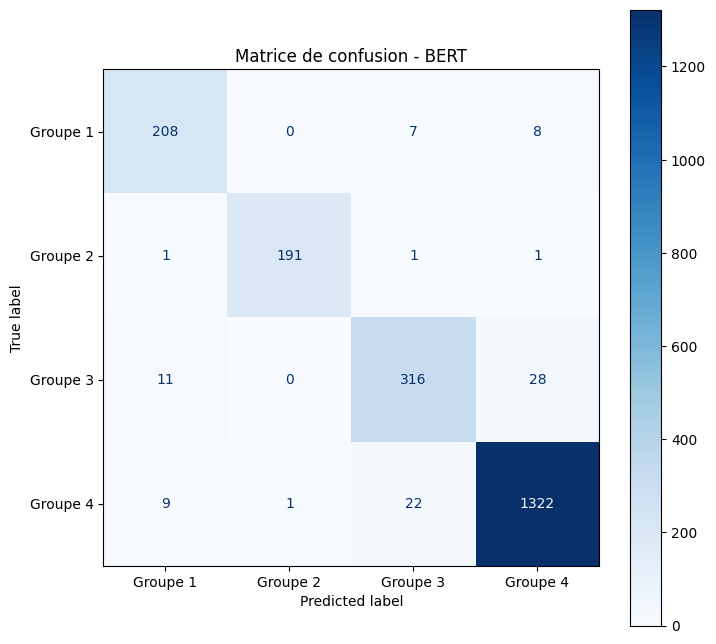

0.958137347130762

In [34]:
evaluate_model(trainer, test_dataset, id2label, title="Matrice de confusion - BERT")

## 3. Classification des scores NOVA avec un encodeur multilingue

### 3.1  Deuxième modèle - Un encodeur multilingue

Décrivez ici le modèle que vous avez choisi. (À compléter)

### 3.2 Entraînement du deuxième modèle


In [62]:
model_path = "nlp_tp2_models/nova/other"
model_id = "microsoft/deberta-v3-small"

In [56]:
train_dataset, dev_dataset, test_dataset = tokenize_all_dataset(train_dataset, dev_dataset, test_dataset)

Map:   0%|          | 0/7651 [00:00<?, ? examples/s]

Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Map:   0%|          | 0/2126 [00:00<?, ? examples/s]

In [ ]:
trainer = trainModel(model_id, model_path, train_dataset, dev_dataset)

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### 3.3 Évaluation du deuxième modèle

## 4. Analyse des résultats et comparaison des 2 modèles